In [1]:
using Pkg
Pkg.instantiate()

In [2]:
# Run simulations for different n and p combinations
using Plots
using Statistics
using Distributions

In [3]:

using LinearAlgebra
include("UpdatableQR.jl")


update_views! (generic function with 1 method)

In [4]:


"""
Fits a linear regression model using QR factorization
X: feature matrix (n × p)
y: target vector (n)
Returns: coefficient vector β (p)
"""
function fit_linear_regression(X::AbstractMatrix{T}, y::AbstractVector{T}) where T
    qr = UpdatableQR(X)
    β = qr.R1 \ (qr.Q1' * y)
    return β
end

"""
Makes predictions using the linear regression model
X: feature matrix (n × p)
β: coefficient vector (p)
Returns: predictions ŷ (n)
"""
function predict_linear_regression(X::AbstractMatrix{T}, β::AbstractVector{T}) where T
    return X * β
end

"""
Updates an existing linear regression model with a new observation
qr: existing UpdatableQR factorization
x: new feature vector
y: new target value
Returns: updated coefficient vector β
"""
function update_linear_regression!(qr::UpdatableQR{T}, 
                                 x::AbstractVector{T}, 
                                 y::T) where T
    add_column!(qr, x)
    β = qr.R1 \ (qr.Q1' * y)
    return β
end

"""
Removes an observation from the linear regression model
qr: existing UpdatableQR factorization
idx: index of observation to remove
y: vector of target values
Returns: updated coefficient vector β
"""
function remove_observation_linear_regression!(qr::UpdatableQR{T}, 
                                            idx::Int, 
                                            y::AbstractVector{T}) where T
    remove_column!(qr, idx)
    β = qr.R1 \ (qr.Q1' * y)
    return β
end

"""
Computes the t-statistic for the i-th coefficient
qr: UpdatableQR factorization
β: coefficient vector
i: index of coefficient
σ: known standard deviation of errors
Returns: t-statistic for β[i]
"""
function t_statistic(qr::UpdatableQR{T}, β::AbstractVector{T}, i::Int, σ::T) where T
    # Get the i-th diagonal element of (X'X)^(-1)
    # For QR factorization, X'X = R'R, so we need (R'R)^(-1)
    ei = zeros(T, qr.m)
    ei[i] = one(T)
    
    # Solve R'z = ei, then Rx = z
    z = qr.R1' \ ei
    
    # The i-th diagonal element of (X'X)^(-1) is the dot product of x with itself
    var_β_i = σ^2 * dot(z, z)
    
    # Compute t-statistic
    t_stat = β[i] / sqrt(var_β_i)
    
    return t_stat
end

t_statistic

In [5]:
"""
Performs forward stepwise selection starting with treatment variable
T: treatment variable (n × 1)
X: feature matrix (n × p)
y: target vector (n)
σ: known standard deviation
max_vars: maximum number of variables to include (optional)
Returns: selected indices and final QR factorization
"""
function forward_stepwise_treatment(
    T::AbstractMatrix{F}, 
    X::AbstractMatrix{F}, 
    y::AbstractVector{F},
    σ::F;
    max_vars::Int = size(X, 2) + 1
) where F
    n, p = size(X)
    selected_indices = Int[]
    available_indices = collect(1:p)
    
    # Initialize with treatment variable
    current_X = copy(T)
    qr = UpdatableQR(current_X)
    β = qr.R1 \ (qr.Q1' * y)
    
    # Store treatment t-statistic
    best_t = abs(t_statistic(qr, β, 1, σ))
    while length(selected_indices) < max_vars 
        
        best_idx = 0
        best_col = zeros(F, n)
        
        # Try each remaining variable
        for j in available_indices
            # Add column temporarily
            col = X[:, j]
            add_column!(qr, col)
            β_try = qr.R1 \ (qr.Q1' * y)
            
            # Check t-statistic for the newly added variable
            t = abs(t_statistic(qr, β_try, 1, σ))
            
            # Remove the column
            remove_column!(qr, qr.m)
            
            # Update best if this t-statistic is larger
            if t > best_t
                best_t = t
                best_idx = j
                best_col = col
            end
        end
        
        # If no improvement found, break
        if best_idx == 0
            break
        end
        
        # Add the best variable permanently
        add_column!(qr, best_col)
        β = qr.R1 \ (qr.Q1' * y)
        
        # Update bookkeeping
        push!(selected_indices, best_idx)
        filter!(x -> x != best_idx, available_indices)
    end
    
    return (
        treatment_t = best_t,
        selected_indices = selected_indices,
        qr = qr,
        β = β
    )
end

# Example usage
n, p = 100, 99
T = (rand(n, 1) .> 0.5) * 1.
X = randn(n, p)
β_true = zeros(p + 1)  # True effect only on treatment
σ = 1.
y = vec(T * β_true[1] + X * β_true[2:end] + σ * randn(n))  # Some noise


result = forward_stepwise_treatment(T, X, y, σ)
println("Treatment t-statistic: ", result.treatment_t)
println("Selected variables: ", result.selected_indices)
println("Final coefficients: ", result.β)

Treatment t-statistic: 3.6709031558255325
Selected variables: [81, 37, 41, 3, 51, 26, 55, 8, 71, 5, 13, 65, 83, 76, 67, 58, 39, 6, 22, 23, 44, 97, 35, 89, 84, 42, 17, 74, 79, 59, 69, 96, 85, 14, 12, 70, 50, 34, 98, 32, 9, 88, 80, 78, 95, 4]
Final coefficients: [-0.7545490122693462, 0.39522219278441667, -0.22802216985960588, -0.15483931649930602, -0.10937374583211594, -0.17128579987852333, -0.1420801121273324, 0.13074286574708952, -0.13515939817778538, 0.22376557378459097, 0.3958296713221188, 0.3249985597156446, -0.08249881923265387, -0.2142250763756887, 0.1724284154097717, 0.18363251572516098, -0.1396280582040411, -0.0028373270548103396, 0.22546271215072344, 0.10698683252207733, -0.22439790060511805, 0.14996067083516543, 0.02009753757624804, -0.09380170413467348, -0.1884389809266962, 0.1406929077684563, 0.03588577568384925, 0.10717898082733358, 0.04000643177115856, 0.08637193933874322, -0.1744213535635857, -0.19031326511661983, -0.11663285226311355, 0.14259946097832693, 0.0384351249244

In [6]:
"""
Runs a single simulation with given parameters
n: number of observations
p: number of covariates
β_treatment: true treatment effect
σ: noise level
Returns: t-statistic for treatment effect
"""
function run_single_simulation(
    n::Int, p::Int, β_treatment::Float64, σ::Float64, max_vars::Int
)
    # Generate data
    T = (rand(n, 1) .> 0.5) * 1.
    X = randn(n, p)
    β_true = [β_treatment; zeros(p)]  # Effect only on treatment
    y = vec(T * β_true[1] + X * β_true[2:end] + σ * randn(n))
    
    # Run stepwise selection
    result = forward_stepwise_treatment(T, X, y, σ, max_vars=max_vars)
    
    return result.treatment_t
end

"""
Runs multiple simulations for given parameters
n_sims: number of simulations
n, p: data dimensions
β_treatment: true treatment effect
σ: noise level
Returns: vector of t-statistics
"""
function run_simulations(
    n_sims::Int, n::Int, p::Int, β_treatment::Float64, σ::Float64, max_vars::Int
)
    t_stats = zeros(n_sims)
    
    for i in 1:n_sims
        t_stats[i] = run_single_simulation(n, p, β_treatment, σ, max_vars)
    end
    
    return t_stats
end

run_simulations

In [7]:
# Run simulations for different n and p combinations
using Plots
using Statistics
using Distributions

# Parameters
n_sims = 500
σ = 1.0
β_treatment = 0.0  # null hypothesis
ns = [100, 200, 500, 1000, 2000, 5000]
ps = [0.05, 0.1, 0.2, 0.5, 0.9]

5-element Vector{Float64}:
 0.05
 0.1
 0.2
 0.5
 0.9

In [6]:
# Run simulations for different n and p combinations
using Plots
using Statistics
using Distributions

# Parameters
n_sims = 500
σ = 1.0
β_treatment = 0.0  # null hypothesis
ns = [100, 200, 500, 1000, 2000, 5000]
ps = [0.05, 0.1, 0.2, 0.5, 0.9]

# Store results
# results = Dict()

for n in ns
    for p in ps
        p = round(Int, n * p)
        if (n, p) in keys(results)
            continue
        end
        s = round(Int, log(p))
        println("Running simulations for n=$n, p=$p, s=$s")
        flush(stdout)
        t_stats = run_simulations(n_sims, n, p, β_treatment, σ, s)
        results[(n, p)] = t_stats
    end
end

Deps path: /Users/njwfish/.julia/packages/FFMPEG/guN1x/src/../deps/deps.jl


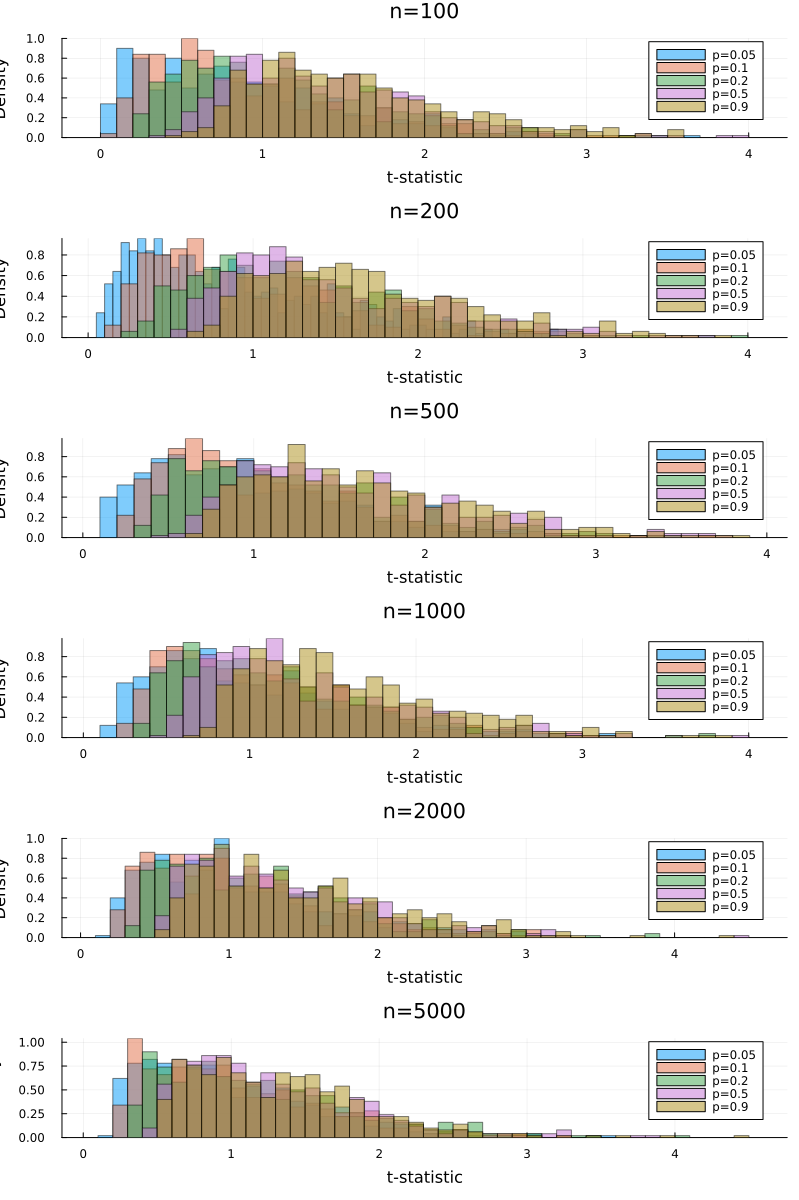

In [99]:
# Plotting
plot_layout = plot(layout=(length(ns), 1), size=(800, 1200))
for (i, n) in enumerate(ns)
    plots = []
    for p in ps
        if !((n, round(Int, n * p)) in keys(results))
            continue
        end
        t_stats = results[(n,round(Int, n * p))]
        histogram!(plot_layout[i], t_stats, 
                  label="p=$p", 
                  alpha=0.5, 
                  normalize=true,
                  bins=50)
    end
    plot!(plot_layout[i], 
          title="n=$n", 
          xlabel="t-statistic", 
          ylabel="Density")
end
display(plot_layout)



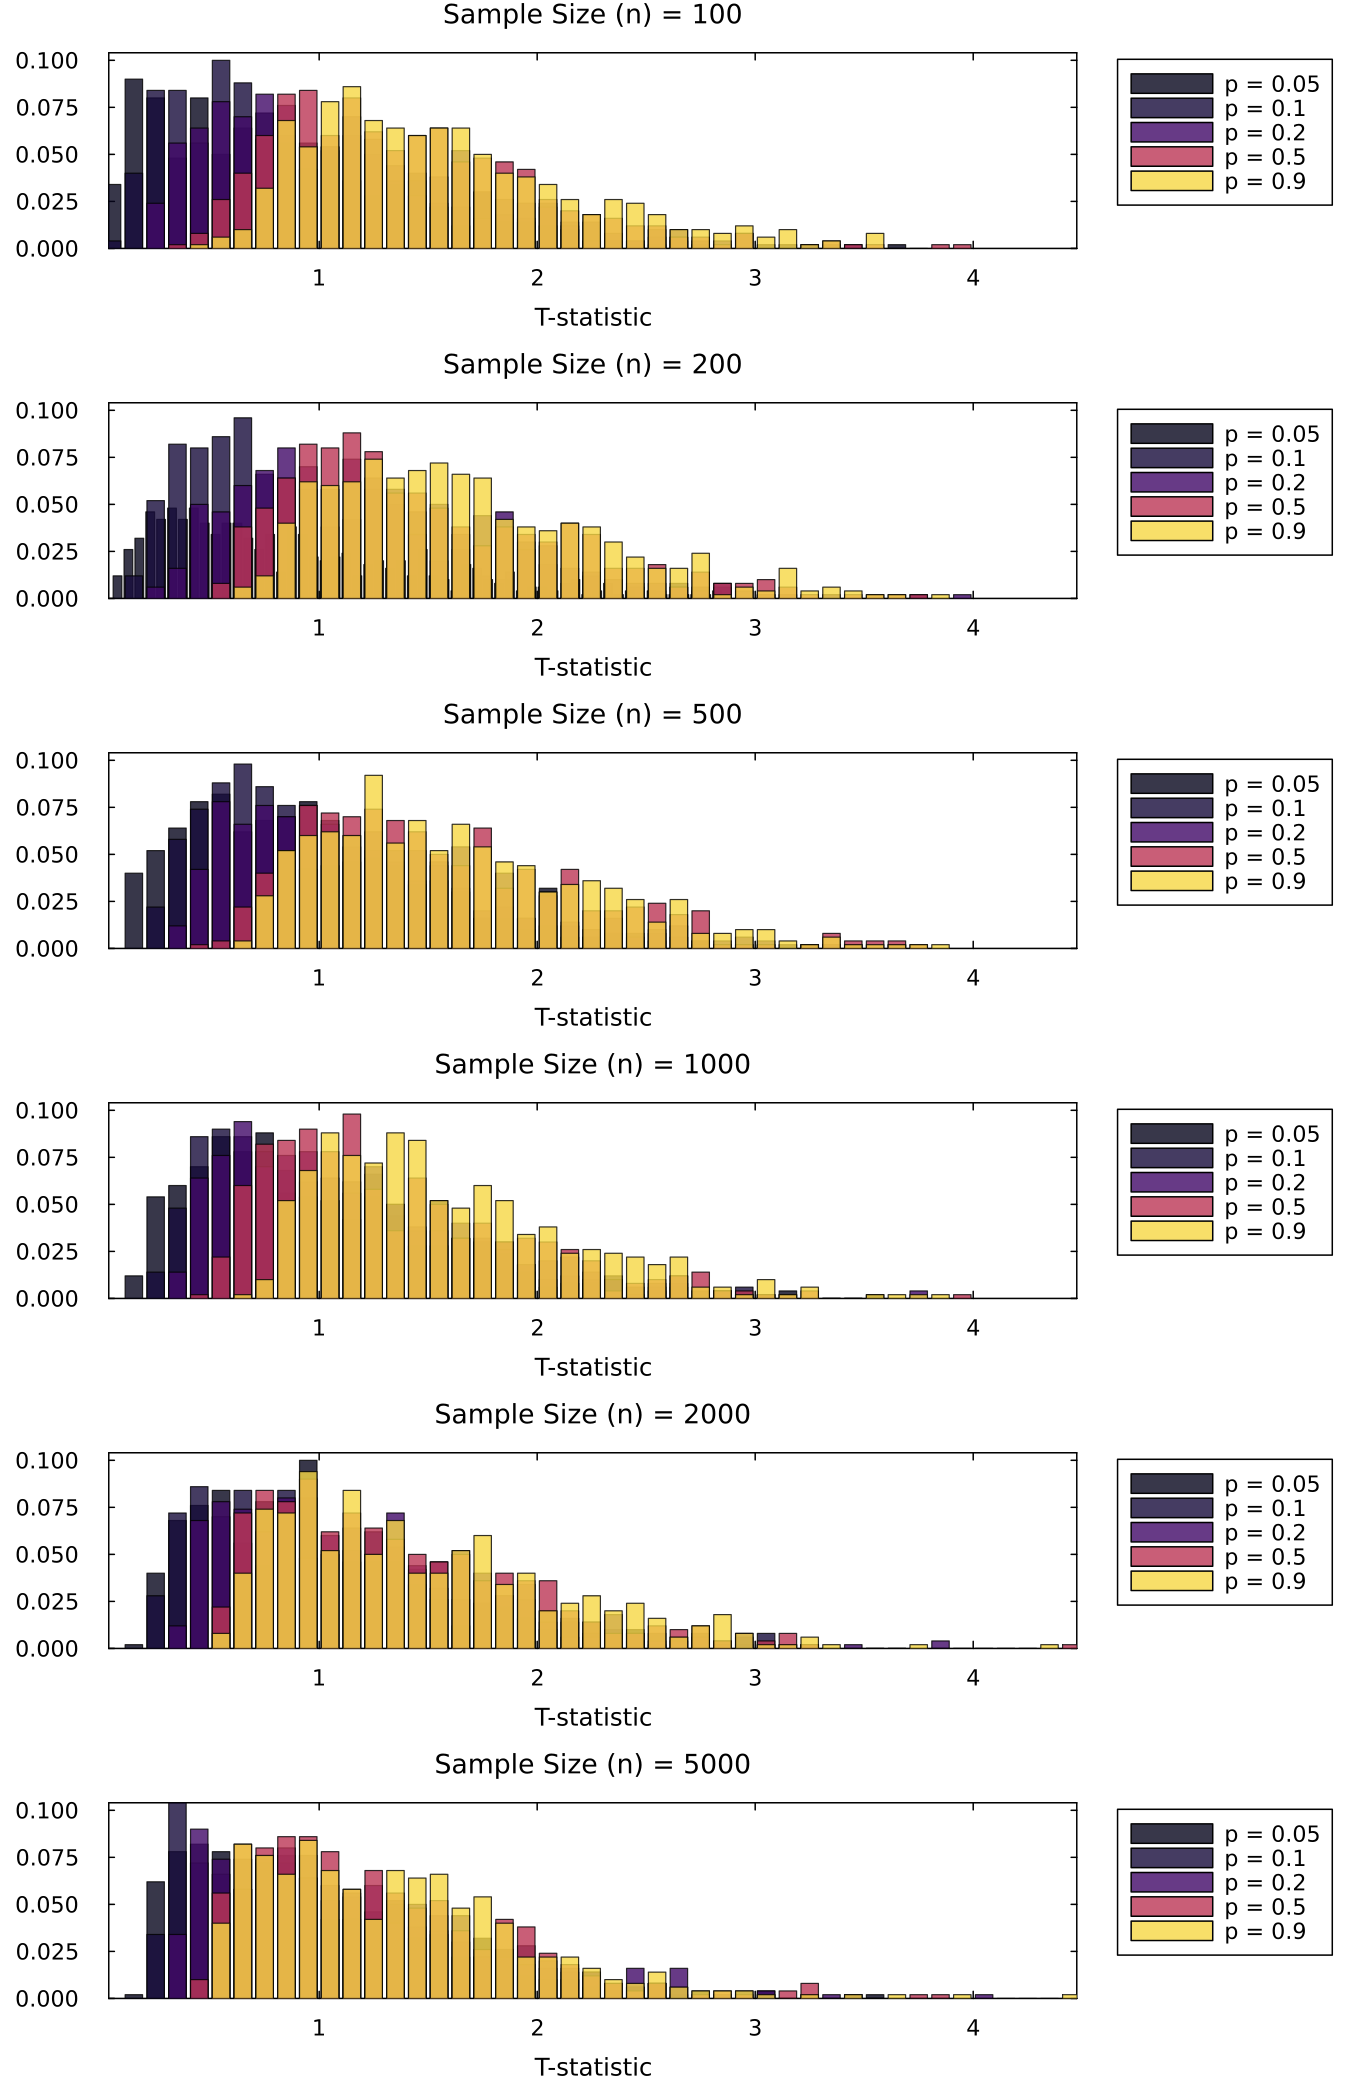

In [28]:
using StatsBase
using Plots
using ColorSchemes  # For color gradients

# Determine the maximum density and consistent x-axis range across all histograms
max_density = 0.0
x_min, x_max = Inf, -Inf

for n in ns
    for p in ps
        if (n, round(Int, n * p)) in keys(results)
            t_stats = results[(n, round(Int, n * p))]
            hist = fit(Histogram, t_stats; nbins=50, closed=:left)
            normalized_weights = hist.weights / sum(hist.weights)  # Normalize manually
            max_density = max(max_density, maximum(normalized_weights))
            x_min = min(x_min, minimum(t_stats))
            x_max = max(x_max, maximum(t_stats))
        end
    end
end

# Color scheme: map `p` to a gradient from blue to red
color_map = ColorSchemes.inferno  # You can try other gradients like `inferno`, `plasma`, etc.

# Create plots with consistent axis limits
plot_layout = plot(layout=(length(ns), 1), size=(900, 1400), dpi=150, 
                   legend=:outertopright, grid=:off, framestyle=:box, link=:both)

for (i, n) in enumerate(ns)
    for p in ps
        if !((n, round(Int, n * p)) in keys(results))
            continue
        end
        t_stats = results[(n, round(Int, n * p))]
        hist = fit(Histogram, t_stats; nbins=50, closed=:left)
        normalized_weights = hist.weights / sum(hist.weights)  # Normalize manually
        bar_positions = collect(hist.edges[1][1:end-1]) .+ diff(hist.edges[1]) ./ 2  # Bin centers
        
        # Determine color based on `p`
        color = get(color_map, p)  # Map p to the gradient

        bar!(plot_layout[i], bar_positions, normalized_weights,
             label="p = $p", alpha=0.8, linewidth=0.8, color=color)
    end
    plot!(plot_layout[i],
          title="Sample Size (n) = $n", 
          xlabel="T-statistic", 
          ylabel="Density",
          xlim=(x_min, x_max),  # Consistent x-axis limits
          ylim=(0, max_density),  # Consistent y-axis limits
          xtickfontsize=10, 
          ytickfontsize=10, 
          legendfontsize=10,
          titlefontsize=12)
end

# Display the plot layout with shared axes and gradient coloring
display(plot_layout)


In [33]:
import Pkg; Pkg.add("Colors")

   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [5ae59095] + Colors v0.13.0
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


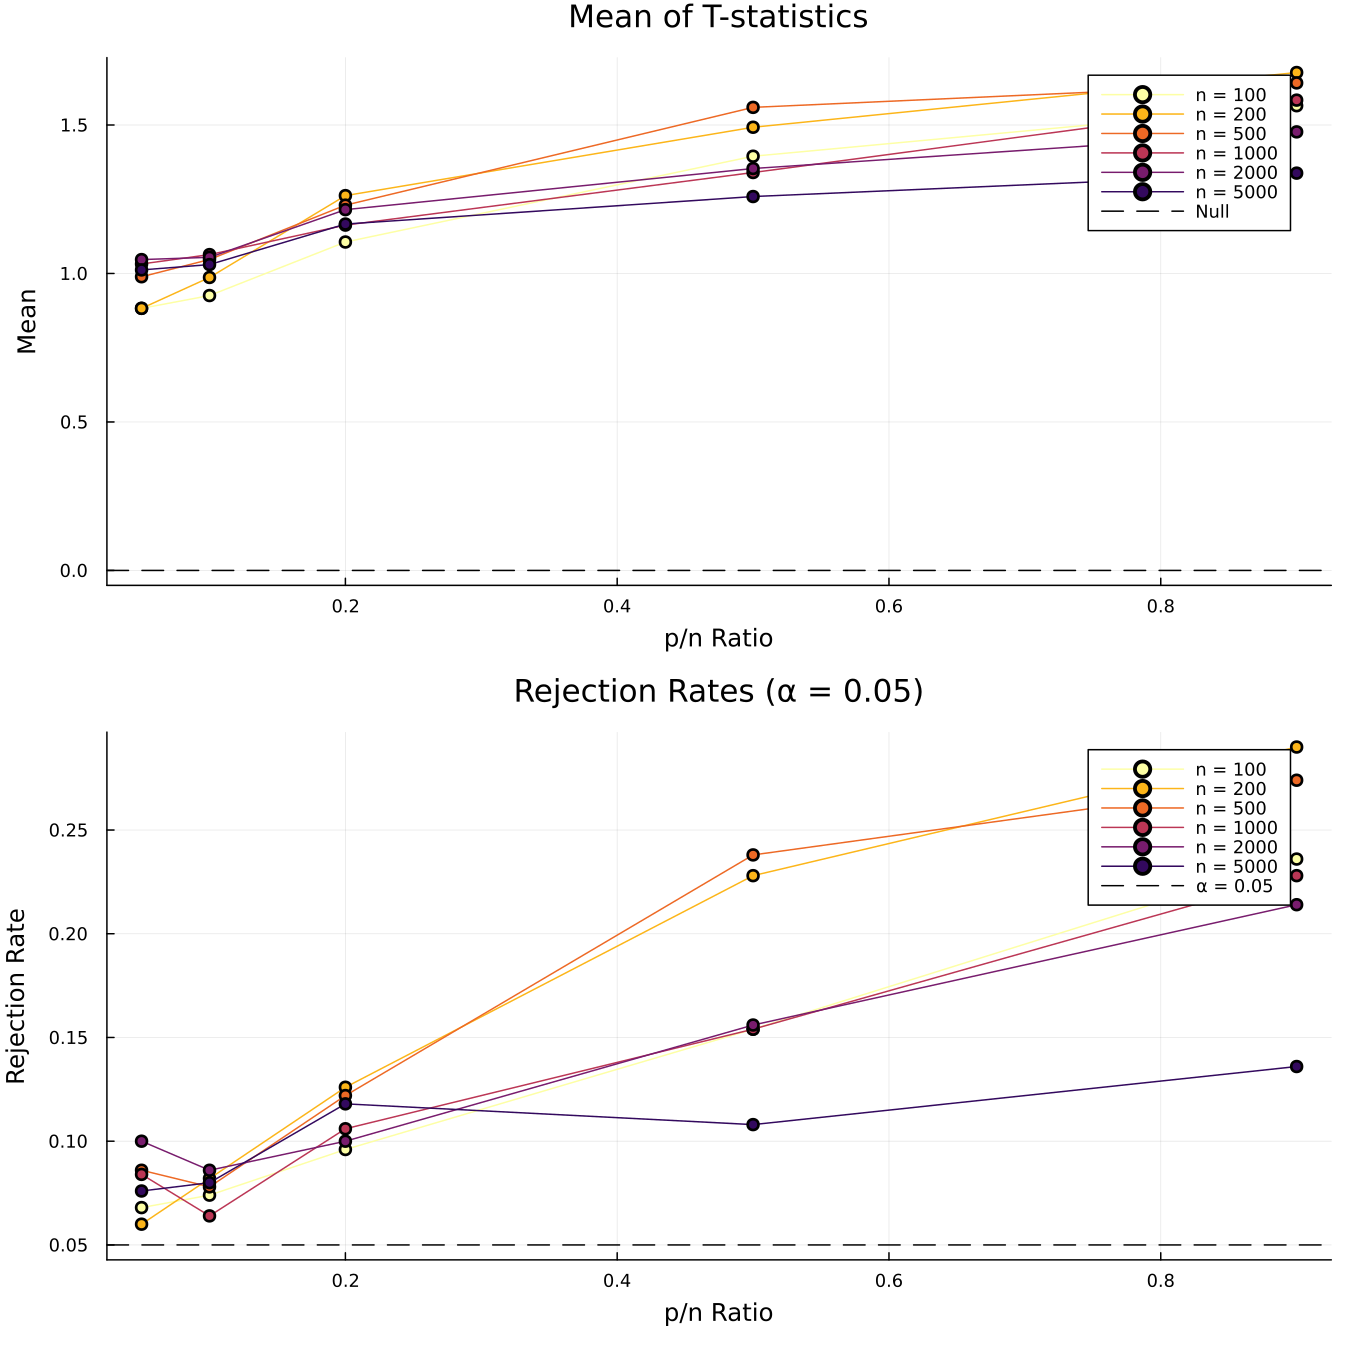

In [38]:
using Plots
using Statistics
using Distributions
using ColorSchemes  # For color schemes

# Assuming we have our `results` dictionary from previous simulations

# Initialize subplots for mean, standard deviation, and rejection rates
p1 = plot(title="Mean of T-statistics", ylabel="Mean", xlabel="p/n Ratio", legend=:topright, dpi=150)
p3 = plot(title="Rejection Rates (α = 0.05)", ylabel="Rejection Rate", xlabel="p/n Ratio", legend=:topright, dpi=150)

# Color scheme: use `inferno` for intensity
color_map = ColorSchemes.inferno
colors = reverse([get(color_map, i / length(ns)) for i in 1:length(ns)])  # One color per `n`

# Plot statistics for each `n`
for (i, n) in enumerate(ns)
    ratios = ps  # These are already our p/n ratios
    means = Float64[]
    stds = Float64[]
    rejections = Float64[]
    
    for p in ps
        if !((n, round(Int, n * p)) in keys(results))
            continue
        end
        t_stats = results[(n, round(Int, n * p))]
        push!(means, mean(t_stats))
        push!(rejections, mean(abs.(t_stats) .> quantile(Normal(), 0.975)))
    end

    # Plot data for each metric
    plot!(p1, ratios[1:length(means)], means, label="n = $n", color=colors[i], marker=:circle)
    plot!(p3, ratios[1:length(means)], rejections, label="n = $n", color=colors[i], marker=:circle)
end

# Add reference lines to each plot
hline!(p1, [0], label="Null", linestyle=:dash, color=:black)
hline!(p3, [0.05], label="α = 0.05", linestyle=:dash, color=:black)

# Combine plots into a single layout
plot_layout = plot(p1, p3, layout=(2, 1), size=(900, 900), link=:both)

# Display the combined plot
display(plot_layout)


In [93]:
# save results
using JLD2
save("results.jld2"; results)




#27 (generic function with 1 method)

In [97]:
results

Dict{Any, Any} with 30 entries:
  (500, 250)   => [1.35624, 3.05557, 1.33485, 2.15642, 1.2255, 0.974545, 0.8097…
  (2000, 1000) => [1.71826, 4.46687, 2.63394, 1.15479, 0.540176, 1.96447, 0.874…
  (5000, 4500) => [0.637006, 0.960344, 2.16191, 0.983849, 1.00568, 0.63175, 1.0…
  (100, 20)    => [0.407918, 1.17136, 1.56293, 1.23773, 2.00856, 0.688629, 1.35…
  (500, 25)    => [0.929606, 2.04613, 1.42661, 0.989107, 0.607328, 1.48769, 1.4…
  (200, 40)    => [1.14537, 2.19632, 2.2414, 1.58521, 1.34317, 1.00062, 1.58503…
  (200, 20)    => [0.636976, 0.79046, 0.314385, 0.638004, 0.996949, 0.477428, 0…
  (500, 450)   => [1.45488, 1.99251, 2.83511, 1.8611, 1.90201, 1.15409, 1.44078…
  (1000, 50)   => [0.346972, 1.42162, 0.643485, 1.35086, 0.697533, 0.713172, 1.…
  (100, 5)     => [0.237745, 1.70238, 0.124408, 0.33909, 0.656562, 2.12892, 0.3…
  (5000, 2500) => [0.579151, 0.875413, 2.23066, 0.689463, 0.674179, 0.765233, 1…
  (100, 90)    => [1.80207, 1.23995, 1.52568, 2.03322, 1.25083, 1.52713, 1.21

In [10]:
using JLD2
results = load("results.jld2")["results"]


Dict{Any, Any} with 30 entries:
  (500, 250)   => [1.35624, 3.05557, 1.33485, 2.15642, 1.2255, 0.974545, 0.8097…
  (2000, 1000) => [1.71826, 4.46687, 2.63394, 1.15479, 0.540176, 1.96447, 0.874…
  (5000, 4500) => [0.637006, 0.960344, 2.16191, 0.983849, 1.00568, 0.63175, 1.0…
  (100, 20)    => [0.407918, 1.17136, 1.56293, 1.23773, 2.00856, 0.688629, 1.35…
  (500, 25)    => [0.929606, 2.04613, 1.42661, 0.989107, 0.607328, 1.48769, 1.4…
  (200, 40)    => [1.14537, 2.19632, 2.2414, 1.58521, 1.34317, 1.00062, 1.58503…
  (200, 20)    => [0.636976, 0.79046, 0.314385, 0.638004, 0.996949, 0.477428, 0…
  (500, 450)   => [1.45488, 1.99251, 2.83511, 1.8611, 1.90201, 1.15409, 1.44078…
  (1000, 50)   => [0.346972, 1.42162, 0.643485, 1.35086, 0.697533, 0.713172, 1.…
  (100, 5)     => [0.237745, 1.70238, 0.124408, 0.33909, 0.656562, 2.12892, 0.3…
  (5000, 2500) => [0.579151, 0.875413, 2.23066, 0.689463, 0.674179, 0.765233, 1…
  (100, 90)    => [1.80207, 1.23995, 1.52568, 2.03322, 1.25083, 1.52713, 1.21

In [6]:
results

Dict{Any, Any} with 30 entries:
  (500, 250)   => [1.35624, 3.05557, 1.33485, 2.15642, 1.2255, 0.974545, 0.8097…
  (2000, 1000) => [1.71826, 4.46687, 2.63394, 1.15479, 0.540176, 1.96447, 0.874…
  (5000, 4500) => [0.637006, 0.960344, 2.16191, 0.983849, 1.00568, 0.63175, 1.0…
  (100, 20)    => [0.407918, 1.17136, 1.56293, 1.23773, 2.00856, 0.688629, 1.35…
  (500, 25)    => [0.929606, 2.04613, 1.42661, 0.989107, 0.607328, 1.48769, 1.4…
  (200, 40)    => [1.14537, 2.19632, 2.2414, 1.58521, 1.34317, 1.00062, 1.58503…
  (200, 20)    => [0.636976, 0.79046, 0.314385, 0.638004, 0.996949, 0.477428, 0…
  (500, 450)   => [1.45488, 1.99251, 2.83511, 1.8611, 1.90201, 1.15409, 1.44078…
  (1000, 50)   => [0.346972, 1.42162, 0.643485, 1.35086, 0.697533, 0.713172, 1.…
  (100, 5)     => [0.237745, 1.70238, 0.124408, 0.33909, 0.656562, 2.12892, 0.3…
  (5000, 2500) => [0.579151, 0.875413, 2.23066, 0.689463, 0.674179, 0.765233, 1…
  (100, 90)    => [1.80207, 1.23995, 1.52568, 2.03322, 1.25083, 1.52713, 1.21

In [69]:
Z = [T X[:, result.selected_indices]]
β_hat = Z \ y
β_hat ./ sqrt.(diag(inv(Z' * Z)))


59-element Vector{Float64}:
  4.771826718299017
  2.3348029079779837
  2.9929685617405326
  2.808853833345339
  2.443067728509252
  0.6642833512441165
 -0.2773371728446515
 -2.5391680112540413
 -0.8856672929455732
 -1.694409453482683
  ⋮
  0.835340392205511
 -0.8129994710851741
  2.0069640365888293
 -0.9739751709980244
  1.1012537424455349
 -0.5728842185728216
 -0.5554391876084898
  0.34786948162729525
  0.05006704062482737